# Natural Language Preprocessing

PDF Scraping and using NLP Techniques to find the answer for questions

In [1]:
import PyPDF2
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
import numpy as np

we are converting the pdf by papers into chunks, because we are using method called TFIDF. To find, in which page we have the most relevant information in the pdf. Because of this limitations of TF-IDF we cannot extract the meaning of the word and answer teh complex questions.

In [2]:
def extract_text(pdf_path):
    text = []
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text.append(page.extract_text())
    return text

pdf_path = "dopamine_detox.pdf"
pdf_text = extract_text(pdf_path)
#printing page no 3
print('Page3 content '+ pdf_text[3])

Page3 content WHO IS THIS BOOK FOR?
Do you keep procrastinating on important jobs? Do you often feel restless
and unable to focus on the task at hand? Do you have trouble getting
excited about the important goals that could improve your life?
If so, you might need a dopamine detox.
In today ’s world  where distractions are everywhere, our ability to focus has
become a scarce commodity . We’re constantly being stimulated, feeling
restless, often without knowing why. When the time comes to focus on the
key tasks that would enable us to make progress toward our goals, we can
often find a plethora of other things to do. Instead of working toward our
goals, we might pop out for a walk, grab a coffee, check our emails or
reorganize our files instead. Everything seems like a great idea— everything
except the very thing we should  be doing.
As we repeat this same pattern every day, we can let our biggest goals and
loftier dreams slip between our fingers. We underperform and accomplish
far less

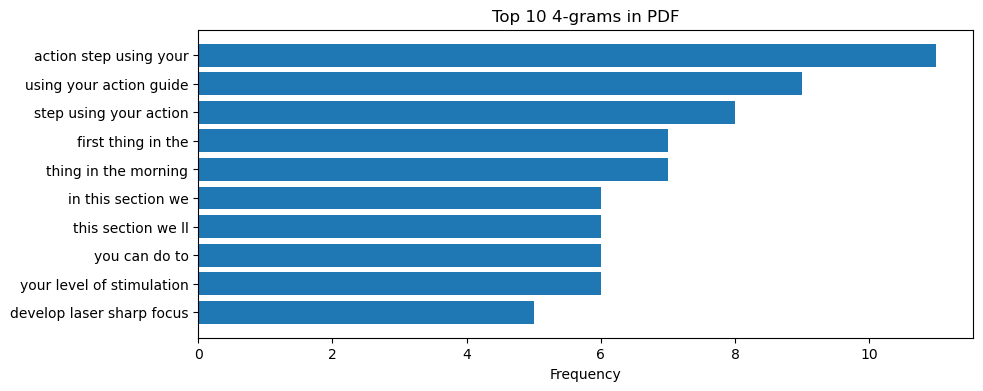

In [3]:
# using n gram to plot
one_para = " ".join(pdf_text)
count_vectorizer = CountVectorizer(ngram_range=(4, 4))

X = count_vectorizer.fit_transform([one_para])
ngrams = count_vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

top_ngrams = Counter(dict(zip(ngrams, counts))).most_common(10)

labels, values = zip(*top_ngrams)
plt.figure(figsize=(10, 4))
plt.barh(labels, values)
plt.gca().invert_yaxis()
plt.title(f"Top 10 4-grams in PDF")
plt.xlabel("Frequency")
plt.show()

In [4]:
#using Term Frequency and Inverse Document Frequency to find how often the word appeared in the sentence
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
embeddings = tfidf_vectorizer.fit_transform(pdf_text)
embeddings_vectors = embeddings.toarray()
print( 'text embeddings are represented as:',embeddings[10])

text embeddings are represented as:   (0, 471)	0.0669255717034683
  (0, 90)	0.046129871289073913
  (0, 1931)	0.06919480693361087
  (0, 459)	0.060361118982467286
  (0, 1718)	0.0401230654255286
  (0, 915)	0.05164058826931766
  (0, 1723)	0.02582029413465883
  (0, 208)	0.04573429179695666
  (0, 674)	0.026317535959442435
  (0, 1705)	0.08889037071811268
  (0, 1457)	0.13194649903429254
  (0, 1154)	0.09225974257814783
  (0, 463)	0.0401230654255286
  (0, 1930)	0.46998726000151114
  (0, 932)	0.05543259917454706
  (0, 1746)	0.1811157295636869
  (0, 1685)	0.04448333078210341
  (0, 135)	0.037367706935406725
  (0, 1704)	0.14500561036928394
  (0, 962)	0.04448333078210341
  (0, 1097)	0.04448333078210341
  (0, 857)	0.09399745200030223
  (0, 1747)	0.05543259917454706
  (0, 1910)	0.06597324951714627
  (0, 117)	0.0669255717034683
  :	:
  (0, 1923)	0.0627924215779483
  (0, 1248)	0.08864260566956597
  (0, 1331)	0.0627924215779483
  (0, 1155)	0.0627924215779483
  (0, 1600)	0.08027602080801602
  (0, 1111)	0.0

In [5]:
print(embeddings_vectors.shape)

(53, 1939)


In [6]:
#we are using FAISS vector index to save the TF-IDF vector embeddings
vector_dim = embeddings_vectors.shape[1]
index = faiss.IndexFlatL2(vector_dim)
index.add(np.array(embeddings_vectors).astype('float32'))
faiss.write_index(index, "my_vectors.index")

## Now we need to retrive the information from the embedding space

In [19]:
#we are passing query to see what information it retrives from pdf 

query = "What is dopamine detox"

# we are using transform so that,it uses same TF-IDF embedding fit_transform vector and give embeding in same space. 
query_vector = tfidf_vectorizer.transform([query]).toarray().astype('float32')

index = faiss.read_index("my_vectors.index")
D, I = index.search(query_vector, k=3)

print("Distances:", D)
print("Indices:", I)

# now we are seeing whether the word passed is in the pdf
for word in query.lower().split():
    print(f"{word} in vocab? ->", word in tfidf_vectorizer.vocabulary_)


Distances: [[1.        1.1048552 1.4072057]]
Indices: [[ 0 25 26]]
what in vocab? -> True
is in vocab? -> True
dopamine in vocab? -> True
detox in vocab? -> True


this means chunk zero is the closest to the query vector, the chunck 25 is slightly , and the chunck 26 is all similar to query vector.

In [21]:
#retriving the information from the matching page
for idx in I[0]:
    print(f"🔹 {pdf_text[idx]}")

🔹 
🔹 PART III
THE BENEFITS OF A DETOX
The differ ent types of dopamine detox  and their r espective benefits
So far, we’ve seen that one of the major problems preventing you doing the
hard work is overstimulation. Therefore, the solution to tackling  your major
tasks is to reduce your level of stimulation. This is what the dopamine detox
is for .
What is dopamine detox?
Dopamine detox describes the following process:
The reduction of stimulation to prevent overstimulation and put you in the
proper state of mind to tackle major tasks.
Quick disclaimer:
Scientifically speaking, the term “dopamine detox” is incorrect  as it seems
to imply  that you’re releasing too much dopamine into your system. In
truth, when you’re overstimulat ed, you simply need more external stimuli
for the same amount  of dopamine to be released.
A dopamine detox helps reduce stimulation, thereby allowing you to revert
to a more natural state. When you need less stimulation, seemingly
🔹 challenging, boring or tedio

# we can see that everything is in text embedding vocab so our query result is able to direct us to write page and able to find all the keyowrd from pdf. 

what if we give any vocab which is out of the library? let see i will run that below

In [28]:
query = " attitude trignomentry keyboard ?"
query_vector = tfidf_vectorizer.transform([query]).toarray().astype('float32')
D, I = index.search(query_vector, k=3)
print("Distances:", D)
print("Indices:", I)
for word in query.lower().split():
    print(f"{word} in vocab? ->", word in tfidf_vectorizer.vocabulary_)

Distances: [[0.         0.99999994 0.99999994]]
Indices: [[ 0  9 12]]
attitude in vocab? -> False
trignomentry in vocab? -> False
keyboard in vocab? -> False
? in vocab? -> False


In [29]:
if np.count_nonzero(query_vector) == 0:
    print("Query vector word are not exist in TF-IDF embedding")
else:
    D, I = index.search(query_vector, k=3)

Query vector word are not exist in TF-IDF embedding


## both query vector and indices vector zero means the keywords passed are not in dictionary